# Lime Runtime Lockfree

## The structure of this folder

The projects list in this folder are eclipse projects, the test cases of all the benchmarks are discussed in [testcase](../../Testcases/Testcases.ipynb)

1. ```~/Lime_Runtime_LockFree_Lib```: includes the lock-free runtime system, static library, used by all the others.
2. ```~/LOT_LockFree```: Leaf-oriented tree benchmark 
3. ```~/LOT_LockFree_test```: Leaf-oriented tree testcases
4. ```~/MR_LockFree```: Mapreduce benchmark
5. ```~/MR_LockFree_test```: Mapreduce testcases
6. ```~/PQ_LockFree```: Priority Queue benchmark
7. ```~/PQ_LockFree_test```: Priority Queue testcases
8. ```~/SANTA_LockFree```: Snata Claus benchmark
9. ```~/SANTA_LockFree_test```:Snata Claus testcases


## The Implementation 

This work is inspired by the Golang's implementation [1].

### Local queue

The local queue data structure:

```C
typedef struct lqueue_t {
    unsigned int runqhead; /* = 0 */
    unsigned int runqtail; /* = 0 */
    void * runq[MAX_RUNQ_SIZE];
}localqueue;
```
The main functions of the Lime Lock-free runtiem system:

1. ```void runqput(void * ptr)```: put obj (ptr) to the local queue
2. ```void *runqget()```: get one obj from the local queue
3. ```void *runqsteal(int t_id)```: try to steal some objs from other worker (t_id)

### Runqput: 
Put one coroutine to the local queue and is executed oly by the worker thread. 
If the run queue is full, puts half of the coroutines on the global queue.

```C
// Put one coroutine on the local queue
// If the run queue is full, puts half of the coroutines on the global queue.
// Executed only by the worker thread.
void runqput(void * ptr){
    unsigned int h, t;

retry:
    h = atomic_Load(&lq[thread_id].runqhead); // load acquire
    t = lq[thread_id].runqtail;
    if(t-h < MAX_RUNQ_SIZE){
        lq[thread_id].runq[t%MAX_RUNQ_SIZE] = ptr;
        atomic_Store(&lq[thread_id].runqtail, t+1); // store release
        return;
    }
    if(runqputslow(ptr, h, t)){
        return;
    }
    goto retry;
}
```
### Runqget:

Get one coroutine from local queue
Executed only by the owner worker thread.

```C
void* runqget(){
    unsigned int h, t;
    void *obj_ptr;

    while(1){
        h = atomic_Load(&lq[thread_id].runqhead); // load-acquire, synchronize with other consumers
        t = lq[thread_id].runqtail;
        if(t==h){
            return NULL;
        }
        obj_ptr = lq[thread_id].runq[h%MAX_RUNQ_SIZE];
        if(atomic_Cas(&lq[thread_id].runqhead, &h, h+1)){// CAS-release, commit the consumption
        	while(!__sync_bool_compare_and_swap((int *)(obj_ptr+8), 0, 1));//busy waiting
        	return obj_ptr;
        }
    }
}
```

### Runqsteal

Steal half of elements from local runnable queue of victim worker threads
and put onto local runnable queue of current worker thread.
Returns one of the stolen elements

```C
void * runqsteal(int t_id){
    unsigned int t, h, n;
    void *obj_ptr;

    t = lq[thread_id].runqtail;
	n = runqgrab(t_id, lq[thread_id].runq, t);
    if (n == 0) {
		return NULL;
	}
	n--;
    obj_ptr = lq[thread_id].runq[(t+n)%MAX_RUNQ_SIZE];

    if (n > 0) {
		h = atomic_Load(&lq[thread_id].runqhead); // load-acquire, synchronize with consumers
		if (t-h+n >= MAX_RUNQ_SIZE) {
			printf("runqsteal: runq overflow");
			exit(1);
		}
		atomic_Store(&lq[thread_id].runqtail, t+n); // store-release, makes the item available for consumption
    }
	if(debug_open)printf("thread %d steals %d coroutines from thread %d\n", thread_id, n+1, t_id);
	while(!__sync_bool_compare_and_swap ((int *)(obj_ptr+8), 0, 1));//busy waiting
	return obj_ptr;
}
```

## The Results

note: Lime_LF represents Lime_Lockfree.

### MR

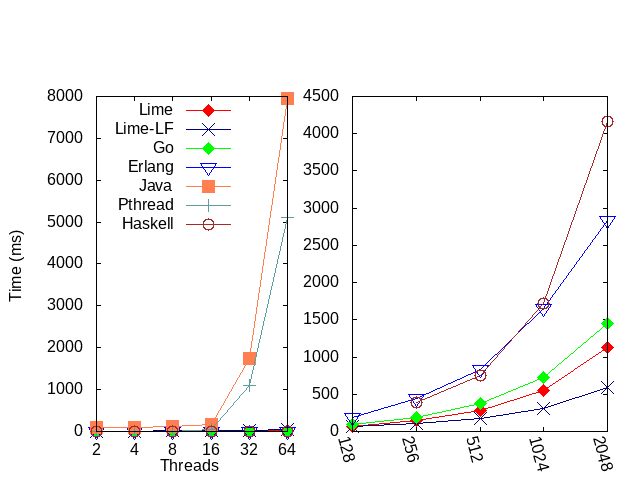

In [8]:
from IPython.display import display, Image
display(Image(filename='./pic/ex_mr.png'))

### PQ

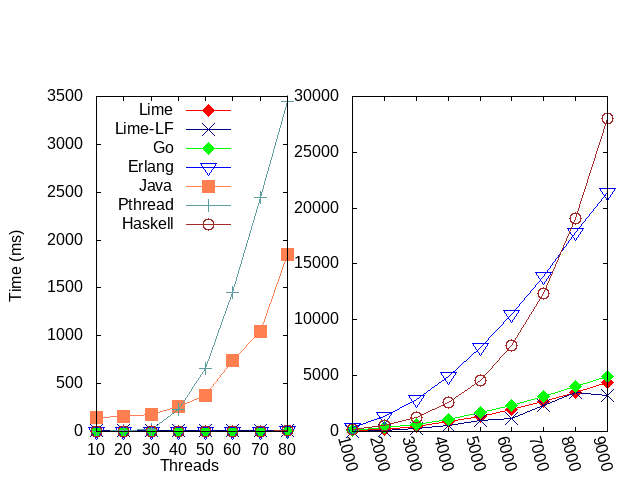

In [9]:
from IPython.display import display, Image
display(Image(filename='./pic/ex_pq.png'))

### LOT

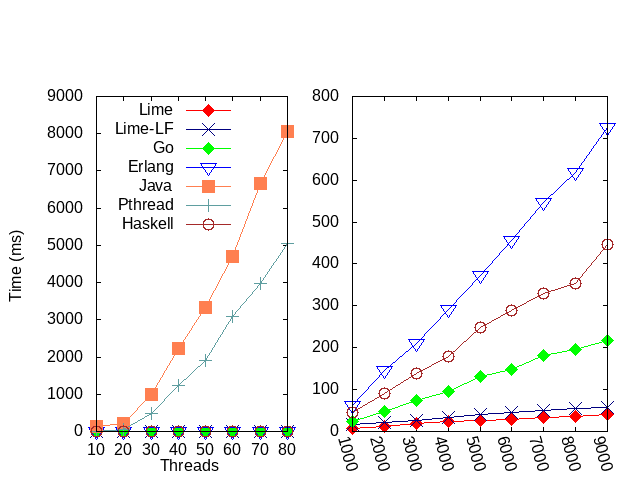

In [10]:
from IPython.display import display, Image
display(Image(filename='./pic/ex_lot.png'))

### SANTA

| Repetitions of Santa | Lime  | Lime_Lockfree | C  | Go  | Java  |
| :-------------|:-----:|:-----:|:-----:|:-----:|-------------|
| 10000 | 0.038 / 0.288 / 0.004 | 0.045 / 0.685 / 0.004 | 0.87 / 0.26 / 1.18 | 0.08 / 0.12 / 0.01 | 6.38 / 2.48 / 5.3 |
| 100000 | 0.363 / 2.887 / 0.004 | 0.579 / 9.233 / 0.000 | 8.82 / 2.50 / 12.0 | 0.77 / 1.18 / 0.06 | 60.3 / 21.6 / 52.0 |
| 1000000 | 3.177 / 25.390 / 0.004 | 4.531 / 72.415 / 0.004 | 93.0 / 24.8 / 123 | 7.51 / 11.6 / 0.55 | 534 / 159 / 509 |

## Analysis

### The context switch

For the privat local queue implementation, each worker thread has a privat local queue which can only be accessed by the worker thread. When the local queue is full, the worker thread tries to move half of the objs to the global queue and wakes up the other worker threads. When the local queue is empty, the worker thread tries to grab some objs from the global queue. If there are no available objs, the worker thread then sleeps. All the active objects have a one-to-one mapping: ***the local queue can have at most one pointer to an active object***. 

The lock-free local queue implementation doesn't have this restriction and the lock-free local queues can have multiple pointers to the same active object: which increases the possiblity of execution of the active objects. 

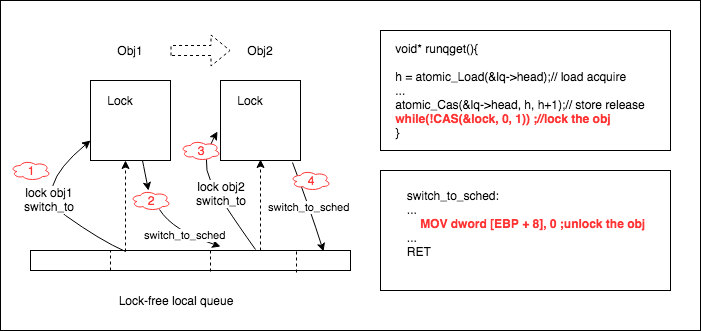

In [11]:
from IPython.display import display, Image
display(Image(filename='./pic/Lockfree_contextswitch.png'))

### The multiple "contexts" of the active objects

Take the santa claus problem as an example, the Lime lockfree runtime system can have multiple pointers in the local queue which point to Santa active object.   

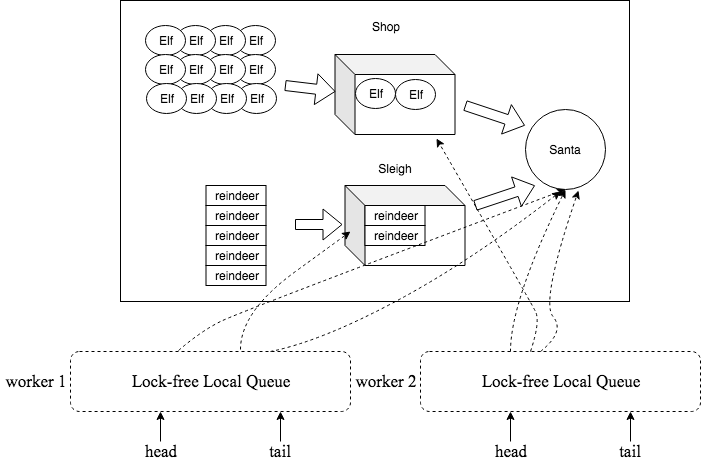

In [12]:
from IPython.display import display, Image
display(Image(filename='./pic/Santa_multiplecontext.png'))

Compared with the Lime lockfree runtime system, the original Lime runtime system can only have at most one pointer to the active object. 

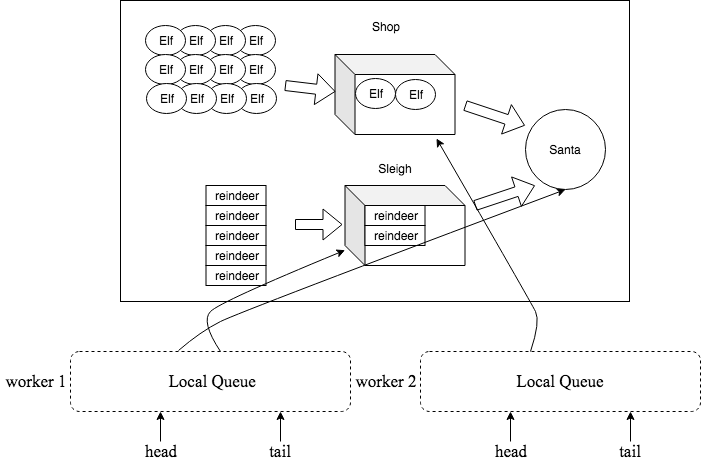

In [13]:
from IPython.display import display, Image
display(Image(filename='./pic/Santa_singlecontext.png'))

### Lock-free local queue and work stealing

1. When the local queue is empty (worker 2), it tries to steal half objs from "victim" worker threads (worker 1). 
2. When the local queue is full, it puts half of the objs to the global queue (linked list && pthread_lock).

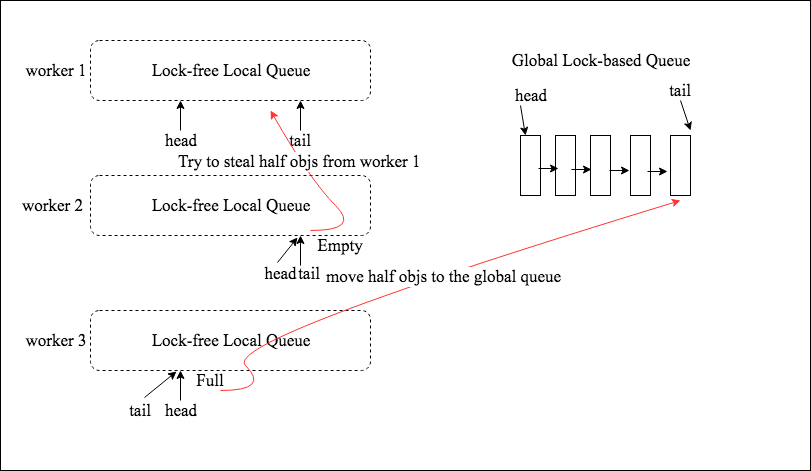

In [14]:
from IPython.display import display, Image
display(Image(filename='./pic/Lime_Lockfree.png'))

### Lock-free local queue

The performance of the lock-free local queue varies from case to case. The lock-free local queue has a positive impact on the two cases (MR && PQ), while, on the other hand, it harms the other two cases (LOT && SANTA). 

#### MR && PQ
1. MR has more than 1000 active objects are available at the same time, and we repeat this for 1024 times to keep the worker thread busy.

2. PQ has a linear structure and contains more than 1000 thousand possible active objects. The worker threads have enough work to finish, apportioning extra overhead of the lock-free implementation.   

#### LOT && SANTA

1. LOT has a bottleneck because of the only data entry of the LOT, which means there are at most $log_{2}N$ active objects can be executed at the same time. For example, LOT tree containing 1000 nodes has only 10 objects can be executed simultaneously.

2. SANTA only has 20 (elves) + 9(reindeer) + 1 (santa) + 1 (shop) + 1 (sleigh) all together.The lock-free implementation does introduce some overhead as expected, but the difference is negligible.

## How to build,  install and run the benchmarks and testcases 

1. For each eclipse projects, the structure are as follow:

``` ~/${benchmark_name} ```: ***benchmarks_name*** = {**MR**, **LOT**, **PQ**, **SANTA**}

``` ~/${benchmark_name}/Debug ```: includes the makefiles and executable objects of the benchmarks

``` ~/${benchmark_name}/src ``` : includes source code of the benchmarks 

``` ~/${benchmark_name}/inc ```: includes header file of the benchmarks

``` ~/${benchmark_name}/${benchmark_name}_Assembly ```: includes the assembly code of the benchmarks


2. ```cd ~/${benchmark_name}/Debug && make all && cp ${benchmark_name} ../../bin ```

## Reference
1. [https://github.com/golang/go/blob/master/src/runtime/proc.go](https://github.com/golang/go/blob/master/src/runtime/proc.go)
